# WASP-80b external data modelling: wavelength-dependent radius ratio

Here we fit the previously published WASP-80b light curves assuming *wavelength-independent radius ratio* and *white noise*. The next step is to model the noise as a Gaussian process, and then allow for *wavelength-dependent radius ratio*.

**Note:** The number of walkers, DE iterations, and MCMC iterations (as well as MCMC thinning and burn-in) have been chosen based on many trial runs. The idea of this notebook is to *just work*.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from extcore import *

In [3]:
class LPFunction(object):
    """A simple log posterior function class.
    """
    def __init__(self, nthreads=2):
        self.tm = MA(interpolate=False, nthr=nthreads) 
        self.nt = nthreads
        
        self.lc_names = ('grond_g grond_r eulercam_r1 grond_i dfosc_I '
                         'grond_z trappist_z1 trappist_z2 grond_J grond_H grond_K').split()
        
        f = pd.HDFStore('data/external_lcs.h5','r')
        self.lcs = [f[n] for n in self.lc_names]
        f.close()

        self.times    = [s.index.values - TZERO for s in self.lcs] 
        self.fluxes   = [s.values for s in self.lcs]                    
        self.npt      = [f.size for f in self.fluxes]
        
        self.unique_pb = 'g r i I z J H K'.split()
        self.passbands = 'g r r i I z z z J H K'.split()
        self.pbids     = [0,1,1,2,3,4,4,4,5,6,7]
        
        self.nlc       = len(self.fluxes)
        self.npb       = len(self.unique_pb)
        self._wrk_ld   = zeros([self.npb,2])
            
        self.priors = [NP(    TC,   5e-3,   'tc'), ##  0  - Transit centre
                       NP(     P,   3e-4,    'p'), ##  1  - Period
                       UP(  3.50,   4.50,  'rho'), ##  2  - Stellar density
                       UP(  0.00,   0.99,    'b')] ##  3  - Impact parameter
        
        self.lc_start = len(self.priors)
        for ilc in range(self.nlc):
            self.priors.extend([UP(1e-4, 3e-2, 'e_{:d}'.format(ilc)),  ##  4 + 2*ilc - White noise std
                                NP( 1.0, 3e-3, 'c_{:d}'.format(ilc))]) ##  5 + 2*ilc - Baseline constant
            
        self.ld_start = len(self.priors)
        for ipb in range(self.npb):
            self.priors.extend([UP(0, 1, 'q1_{:d}'.format(ipb)),  ##  7 + 2*ipb - limb darkening q1
                                UP(0, 1, 'q2_{:d}'.format(ipb))]) ##  8 + 2*ipb - limb darkening q2
            
        self.k_start = len(self.priors)
        for ipb in range(self.npb):
            self.priors.append(UP(0.16**2, 0.18**2, 'k2_{:d}'.format(ipb))) ##  8 + ipb - radius ratio factor            
        self.ps = PriorSet(self.priors)
        
        
    def compute_baseline(self, pv):
        """Simple constant baseline model"""
        return pv[5:5+self.nlc*2:2]
    
    
    def compute_transit(self, pv):
        """Transit model"""
        _a  = as_from_rhop(pv[2], pv[1]) 
        _i  = mt.acos(pv[3]/_a) 

        flux_m = []
        for ipb, (ilc, time) in zip(self.pbids, enumerate(self.times)):
            _k = mt.sqrt(pv[self.k_start+ipb])
            a,b = sqrt(pv[self.ld_start+2*ipb]), 2.*pv[self.ld_start+1+2*ipb]
            self._wrk_ld[ipb,0] = a*b
            self._wrk_ld[ipb,1] = a*(1.-b)
            z = of.z_circular(self.times[ilc], pv[0], pv[1], _a, _i, self.nt) 
            flux_m.append(self.tm(z, _k, self._wrk_ld[ipb]))
            
        return flux_m

    
    def compute_lc_model(self, pv):
        """Combined baseline and transit model"""
        return [b*m for b,m in zip(self.compute_baseline(pv),self.compute_transit(pv))]


    def __call__(self, pv):
        """Log posterior density"""
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -inf
        flux_m = self.compute_lc_model(pv)
        
        return (self.ps.c_log_prior(pv) + 
                sum([ll_normal_es(self.fluxes[i], flux_m[i], pv[4+2*i]) 
                                              for i in range(self.nlc)]))


In [4]:
lpf = LPFunction()

In [5]:
lpf.ps.ndim

50

In [5]:
npop = 150
de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf)

In [6]:
pvp = pd.read_hdf('results/external.h5', 'ckwn/mc')

In [7]:
de._population[:,:4] = pvp.values[:,:4]
de._population[:,4:lpf.k_start] = pvp.values[:,5:]

In [9]:
de.optimize(1000);
sampler.run_mcmc(de.population, 10000);

In [38]:
fc = sampler.chain[:,2000::100,:].reshape([-1,lpf.ps.ndim])
mp = median(fc,0)

In [39]:
dfde = pd.DataFrame(de.population, columns=lpf.ps.names)
dfmc = pd.DataFrame(sampler.chain[:,-1,:], columns=lpf.ps.names)
dffc = pd.DataFrame(fc, columns=lpf.ps.names)

In [40]:
dfde.to_hdf('results/external.h5','/vkwn/de')
dfde.to_hdf('results/external.h5','/vkwn/mc')
dffc.to_hdf('results/external.h5','/vkwn/fc')

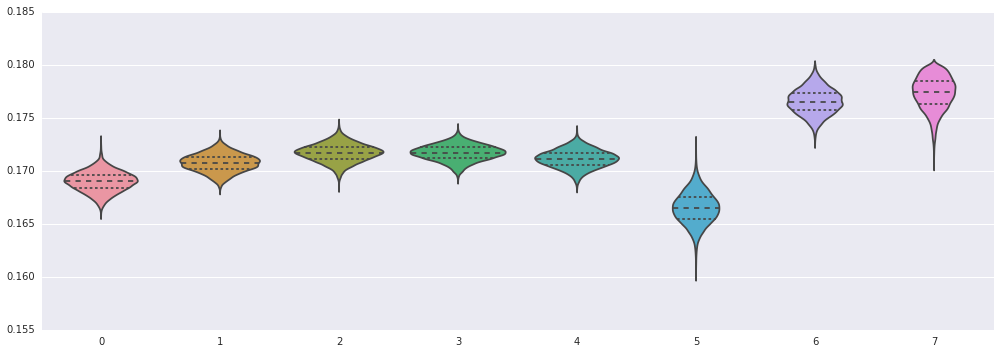

In [41]:
fig,ax = subplots(1,1,figsize=(14,5),sharey=True)
sb.violinplot(data=sqrt(dffc[['k2_%i'%i for i in range(8)]].values), ax=ax, inner='quartile')
fig.tight_layout()

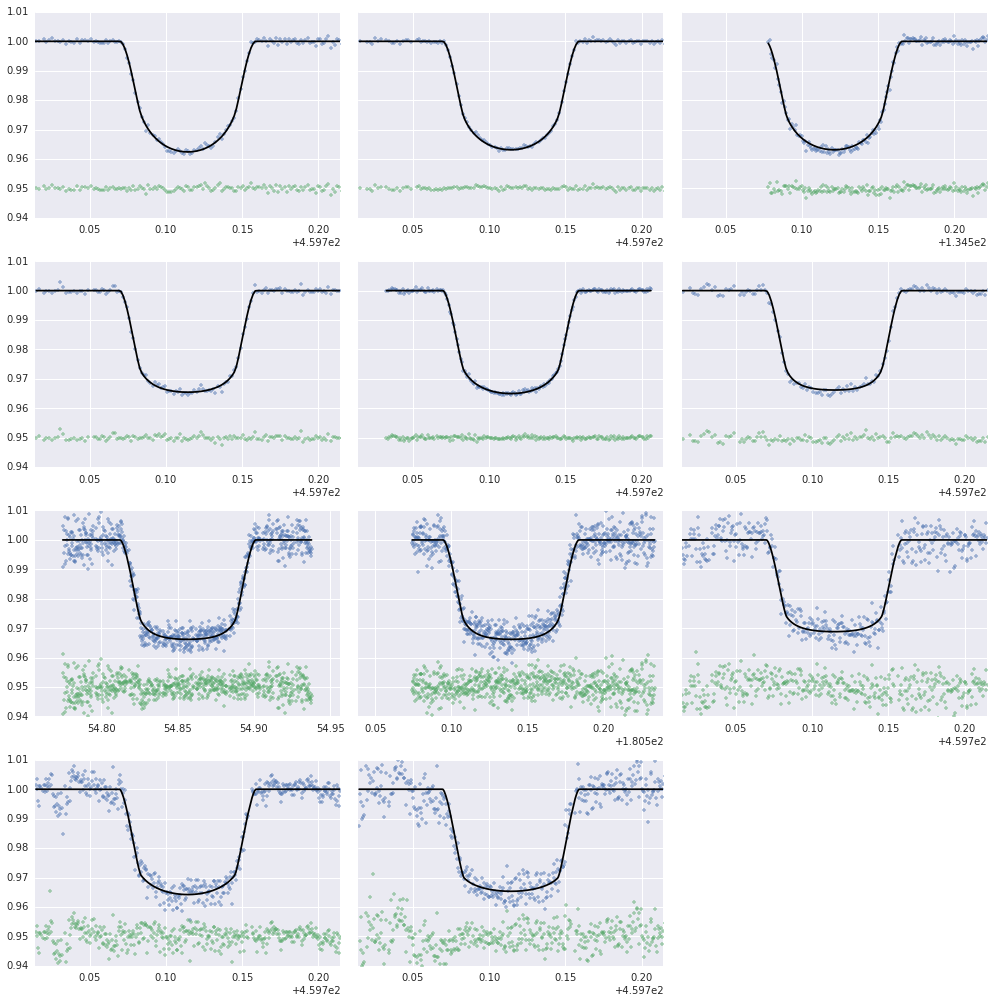

In [42]:
tn = np.round((array(map(mean, lpf.times)) - TC) / P)
xlims = [[TC+n*P-0.1, TC+n*P+0.1,] for n in tn]
flux_m = lpf.compute_transit(mp)
fig,axs = subplots(4,3, figsize=(14,14),sharey=True)
[a.plot(t,f,'.', alpha=0.5) for a,t,f in zip(axs.flat,lpf.times,lpf.fluxes)]
[a.plot(t,f,'k') for a,t,f in zip(axs.flat,lpf.times,flux_m)]
[a.plot(t,fo-fm+0.95,'.', alpha=0.5) for a,t,fo,fm in zip(axs.flat,lpf.times,lpf.fluxes,flux_m)]
[setp(a, xlim=xlim) for a,xlim in zip(axs.flat,xlims)]
setp(axs, ylim=(0.94,1.01))
fig.tight_layout()
axs.flat[-1].set_visible(False)